# 3x3 assembly inputfile that: 

### Import module/Set up XS path/Create openMC model/Clean directory

In [13]:
import sys
import os 
import openmc
import numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs
import pandas as pd
from IPython.display import Image
import glob

### Ragusa environnement

import os

# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'
os.environ['PATH'] += r':/Users/jean.ragusa/repo/openmc/local/bin'

# Add location of OpenMC xs data
%env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml
# %env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/nndc_hdf5/cross_sections.xml

### Pablo environnement

In [14]:
model=openmc.Model()

clean_file_list = ["model.xml", "materials.xml", "geometry.xml","plots.xml","geometry.xml","settings.xml","tallies.out","summary.h5","statepoint.50.h5"]
for file in clean_file_list :
    path_file = os.path.join(os.getcwd(), file)
    if os.path.exists(path_file):
        os.remove(path_file)

### Define Materials

In [15]:
uo2 = openmc.Material(name='uo2')
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)
zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)
water = openmc.Material(name="water")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')
model.materials = openmc.Materials([uo2, zirconium, water]) 
#Perso path
#model.materials.cross_sections = '/home/pablo/internship/xs_for_input/cross_sections.xml'
#Mac path
model.materials.cross_sections = '/Users/pablogarcia44/repo/cross_sections.xml'

### Create pincell

In [16]:

fuel_outer_radius = openmc.ZCylinder(r=0.39)
clad_inner_radius = openmc.ZCylinder(r=0.40)
clad_outer_radius = openmc.ZCylinder(r=0.46)
pitch = 1.26
left = openmc.XPlane(-pitch/2, boundary_type='transmission')
right = openmc.XPlane(pitch/2, boundary_type='transmission')
bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
top = openmc.YPlane(pitch/2, boundary_type='transmission')
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius
water_region = +left & -right & +bottom & -top & +clad_outer_radius
fuel = openmc.Cell(name='fuel_1_family')
fuel.fill = uo2
fuel.region = fuel_region
gap = openmc.Cell(name='gap_1_family')
gap.region = gap_region
clad = openmc.Cell(name='clad_1_family')
clad.fill = zirconium
clad.region = clad_region
moderator = openmc.Cell(name='moderator_1_family')
moderator.fill = water
moderator.region = water_region 
pincell = openmc.Universe(name='pincell_1_family',cells=(fuel, gap, clad, moderator))

### Create guide tube

In [17]:
clad_inner_radius = openmc.ZCylinder(r=0.5610)
clad_outer_radius = openmc.ZCylinder(r=0.6020)
pitch = 1.26
left = openmc.XPlane(-pitch/2, boundary_type='transmission')
right = openmc.XPlane(pitch/2, boundary_type='transmission')
bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
top = openmc.YPlane(pitch/2, boundary_type='transmission')       
clad_region = +clad_inner_radius & -clad_outer_radius
water_region = +left & -right & +bottom & -top & +clad_outer_radius
water_guide_region= -clad_inner_radius
water_guide = openmc.Cell(name='water_guide_1_family')
water_guide.fill = water
water_guide.region = water_guide_region
clad = openmc.Cell(name='clad_guide_1_family')
clad.fill = zirconium
clad.region = clad_region
moderator = openmc.Cell(name='moderator_1_family')
moderator.fill = water
moderator.region = water_region 
guide = openmc.Universe(name='guide_1_family',cells=(water_guide, clad, moderator))

### Mapping GT

In [18]:
GT=[(5,2),(8,2),(3,3),(2,5),(5,5),(8,5),(2,8),(5,8),(8,8)]

GT_left=[]
GT_full=[]
for X in GT:
    GT_left.append((X[0],X[1]))
    GT_left.append((X[0],16-X[1]))
for X in GT_left:
    GT_full.append((X[0],X[1]))
    GT_full.append((16-X[0],X[1]))    
GT_full = list(set(GT_full))

### Define assembly

In [20]:
assembly = openmc.RectLattice()
pitch=1.26

dr=2e-1 # cm of water that is outside assembly
size=17 #size of the assembly 
pitch_assembly=size*pitch+2*dr #(17x1,26)
assembly.pitch = (pitch,pitch)

assembly.lower_left = (-size/2*pitch, -size/2*pitch)


A= np.empty((size, size), dtype=openmc.universe.Universe)

for ix in range(size):
    for iy in range(size):
        if (ix,iy) in GT : 
            A[ix][iy]=guide
        else:
            A[ix][iy]=pincell
            
            print(ix,iy,'not gt')
        # indices_y = np.where(template_y == iy)[0]
        # if any(i in indices_y for i in indices_x):
        #     A[ix][iy]=guide(ix,iy)[0]
        # else:
        #     A[ix][iy]=pincell(ix,iy)[0]

        
assembly.universes = A

moderator_outside = openmc.Cell()
moderator_outside.fill = water
all_water = openmc.Universe()
all_water.add_cell(moderator_outside)
assembly.outer=all_water

# 1/4 assembly
min_x = openmc.XPlane(x0=-(size/2*pitch+dr), boundary_type='reflective')
max_x = openmc.XPlane(x0=0, boundary_type='reflective')
min_y = openmc.YPlane(y0=0, boundary_type='reflective')
max_y = openmc.YPlane(y0=+(size/2*pitch+dr), boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')


root_cell = openmc.Cell(name='root cell', fill=assembly)
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

model.geometry.root_universe = openmc.Universe(name='root universe')
model.geometry.root_universe.add_cell(root_cell)



0 0 not gt
0 1 not gt
0 2 not gt
0 3 not gt
0 4 not gt
0 5 not gt
0 6 not gt
0 7 not gt
0 8 not gt
0 9 not gt
0 10 not gt
0 11 not gt
0 12 not gt
0 13 not gt
0 14 not gt
0 15 not gt
0 16 not gt
1 0 not gt
1 1 not gt
1 2 not gt
1 3 not gt
1 4 not gt
1 5 not gt
1 6 not gt
1 7 not gt
1 8 not gt
1 9 not gt
1 10 not gt
1 11 not gt
1 12 not gt
1 13 not gt
1 14 not gt
1 15 not gt
1 16 not gt
2 0 not gt
2 1 not gt
2 2 not gt
2 3 not gt
2 4 not gt
2 6 not gt
2 7 not gt
2 9 not gt
2 10 not gt
2 11 not gt
2 12 not gt
2 13 not gt
2 14 not gt
2 15 not gt
2 16 not gt
3 0 not gt
3 1 not gt
3 2 not gt
3 4 not gt
3 5 not gt
3 6 not gt
3 7 not gt
3 8 not gt
3 9 not gt
3 10 not gt
3 11 not gt
3 12 not gt
3 13 not gt
3 14 not gt
3 15 not gt
3 16 not gt
4 0 not gt
4 1 not gt
4 2 not gt
4 3 not gt
4 4 not gt
4 5 not gt
4 6 not gt
4 7 not gt
4 8 not gt
4 9 not gt
4 10 not gt
4 11 not gt
4 12 not gt
4 13 not gt
4 14 not gt
4 15 not gt
4 16 not gt
5 0 not gt
5 1 not gt
5 3 not gt
5 4 not gt
5 6 not gt
5 7 not 

### Plot

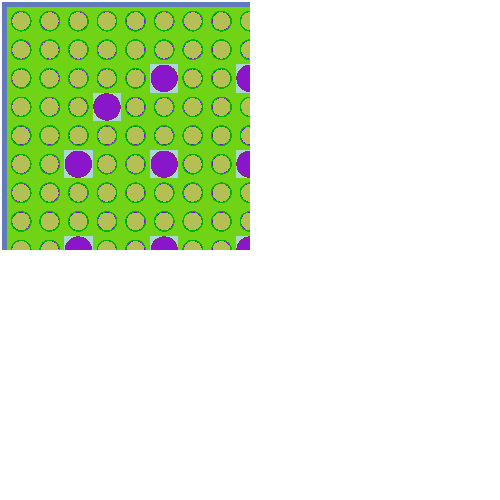

In [21]:
model.materials.export_to_xml()
model.geometry.export_to_xml()
plot = openmc.Plot.from_geometry(model.geometry)
plot.pixels = (500, 500)
plot.width = (pitch_assembly+dr, pitch_assembly+dr)
plot.origin = (0., 0., 0)
plot.color_by = 'cell'
# plot.colors = {
#     water: 'blue',
#     zirconium: 'black',
#     helium: 'yellow',
#     uo2_in: (100, 0, 0),
#     uo2_out: (255, 0, 0)
# }
plot.to_ipython_image()

### Choose settings

In [12]:
bounds = [-pitch_assembly/2, 0, -10, 0, +pitch_assembly/2, 10]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
source = openmc.IndependentSource(space=uniform_dist)
source.time = openmc.stats.Uniform(0, 1e-6)
settings = openmc.Settings()
settings.source = source
settings = openmc.Settings()
settings.source = source
settings.batches = 50
settings.inactive = 10
settings.particles = 500000
settings.output = {'tallies':True}
model.settings = settings

### Define and choose energy group

In [13]:
choose_group=openmc.mgxs.GROUP_STRUCTURES['XMAS-172']
name_group='XMAS172'

### Create MGXS tallies for mgxs directory

In [14]:
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(choose_group)
mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.legendre_order = 3
mgxs_lib.mgxs_types = ['total', 'absorption', 'fission', 'nu-fission', 'chi', 'scatter matrix', 'nu-scatter matrix', 'inverse-velocity']
mgxs_lib.tally_trigger =openmc.Trigger('std_dev', 1e-2)
mgxs_lib.by_nuclide = False
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = model.geometry.get_all_material_cells().values()
mgxs_lib.build_library()
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)
model.tallies = tallies

#model.export_to_xml()
model.export_to_model_xml()

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x78b6e1989ee0>>
Traceback (most recent call last):
  File "/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x78b6e1989ee0>>
Traceback (most recent call last):
  File "/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

### Run OpenMC model

sp_file = model.run()